In [1]:
!nvidia-smi

Mon Jun  9 15:13:22 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.247.01             Driver Version: 535.247.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           On  | 00000000:89:00.0 Off |                    0 |
| N/A   32C    P0              44W / 300W |      0MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
from IPython.display import Image
from ultralytics import YOLO
from tqdm import tqdm_notebook as tqdm
import supervision as sv
import numpy as np
from tqdm.notebook import tqdm
from sports.common.team import TeamClassifier
import torch
import cv2
from sports.configs.soccer import SoccerPitchConfiguration
from sports.annotators.soccer import draw_pitch, draw_points_on_pitch, draw_pitch_voronoi_diagram, draw_paths_on_pitch
from collections import deque 

In [ ]:
DATASET_LOCATION = "football-players-detection-14"

!yolo task=detect mode=train model=yolo11n.pt data={DATASET_LOCATION}/data.yaml batch=6 epochs=50 imgsz=1280 plots=True

In [ ]:
DATASET_LOCATION = "football-field-detection-15"

!yolo task=pose mode=train model=yolov8x-pose.pt data={DATASET_LOCATION}/data.yaml batch=16 epochs=500 imgsz=640 mosaic=0.0 plots=True

In [9]:
PLAYER_DETECTION_MODEL = YOLO("players_model_best.pt")
FIELD_DETECTION_MODEL = YOLO("field_model_best.pt")

SOURCE_VIDEO_PATH = "test.mp4"

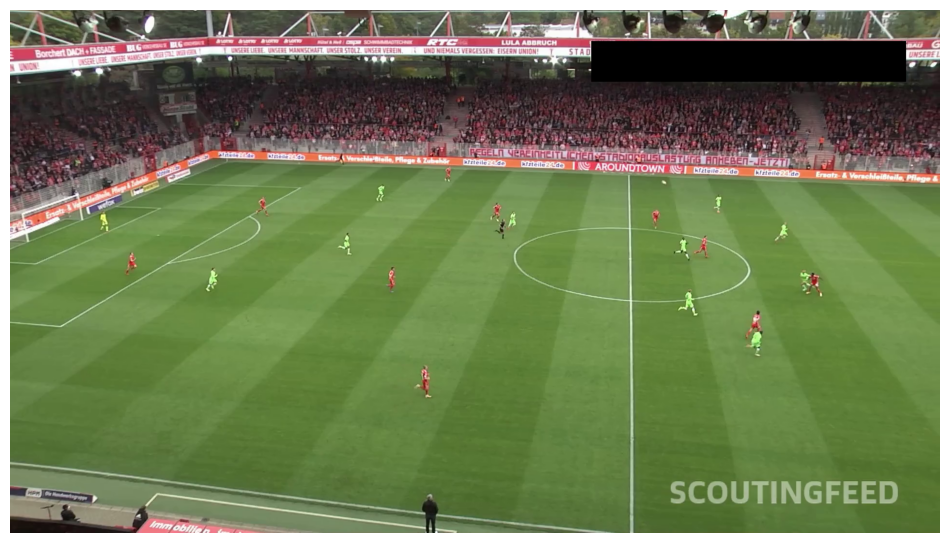

In [10]:
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

sv.plot_image(frame)


0: 736x1280 2 goalkeepers, 21 players, 2 referees, 260.3ms
Speed: 17.5ms preprocess, 260.3ms inference, 20.4ms postprocess per image at shape (1, 3, 736, 1280)


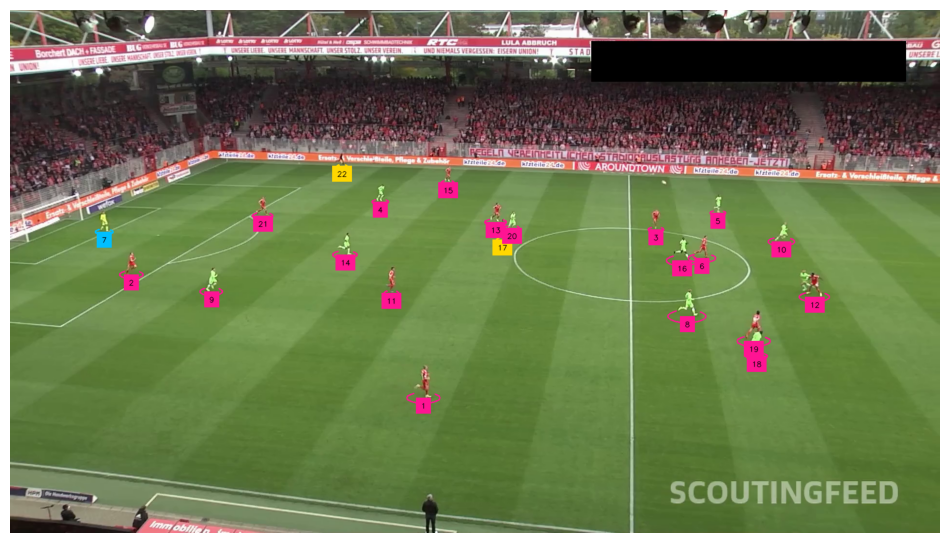

In [12]:
BALL_ID = 0

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), 
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), 
    text_color=sv.Color.from_hex('#000000'), 
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'), 
    base=20,
    height=17
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)
detections = sv.Detections.from_ultralytics(result[0])

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections.class_id = all_detections.class_id - 1
all_detections = tracker.update_with_detections(all_detections)

labels = [f"{tracker_id}" for tracker_id in all_detections.tracker_id]

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(annotated_frame, all_detections)
annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)
annotated_frame = label_annotator.annotate(annotated_frame, all_detections, labels=labels)

sv.plot_image(annotated_frame)

In [13]:
TARGET_VIDEO_PATH = "test_result_1.mp4"

BALL_ID = 0

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), 
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), 
    text_color=sv.Color.from_hex('#000000'), 
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'), 
    base=20,
    height=17
)

tracker = sv.ByteTrack()
tracker.reset()

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

with video_sink:
  for frame in tqdm(frame_generator, total=video_info.total_frames):
    result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)
    detections = sv.Detections.from_ultralytics(result[0])
    
    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
    
    all_detections = detections[detections.class_id != BALL_ID]
    all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
    all_detections.class_id = all_detections.class_id - 1
    all_detections = tracker.update_with_detections(all_detections)
    
    labels = [f"{tracker_id}" for tracker_id in all_detections.tracker_id]
    
    annotated_frame = frame.copy()
    annotated_frame = ellipse_annotator.annotate(annotated_frame, all_detections)
    annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)
    annotated_frame = label_annotator.annotate(annotated_frame, all_detections, labels=labels)

    video_sink.write_frame(annotated_frame)

  0%|          | 0/750 [00:00<?, ?it/s]


0: 736x1280 2 goalkeepers, 22 players, 2 referees, 143.4ms
Speed: 24.5ms preprocess, 143.4ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 144.1ms
Speed: 6.3ms preprocess, 144.1ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 142.7ms
Speed: 9.1ms preprocess, 142.7ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 3 referees, 139.8ms
Speed: 7.8ms preprocess, 139.8ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 3 referees, 142.0ms
Speed: 7.9ms preprocess, 142.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 23 players, 2 referees, 229.4ms
Speed: 6.3ms preprocess, 229.4ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 19 play

collecting crops: 0it [00:00, ?it/s]


0: 736x1280 2 goalkeepers, 21 players, 2 referees, 117.2ms
Speed: 23.9ms preprocess, 117.2ms inference, 0.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 23 players, 1 referee, 117.2ms
Speed: 6.6ms preprocess, 117.2ms inference, 0.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 3 referees, 114.2ms
Speed: 6.7ms preprocess, 114.2ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 1 referee, 118.9ms
Speed: 22.7ms preprocess, 118.9ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 213.0ms
Speed: 7.5ms preprocess, 213.0ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 21 players, 2 referees, 225.4ms
Speed: 7.4ms preprocess, 225.4ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 2 referees, 129.4ms
Speed: 22.1ms preprocess, 129.4ms infere

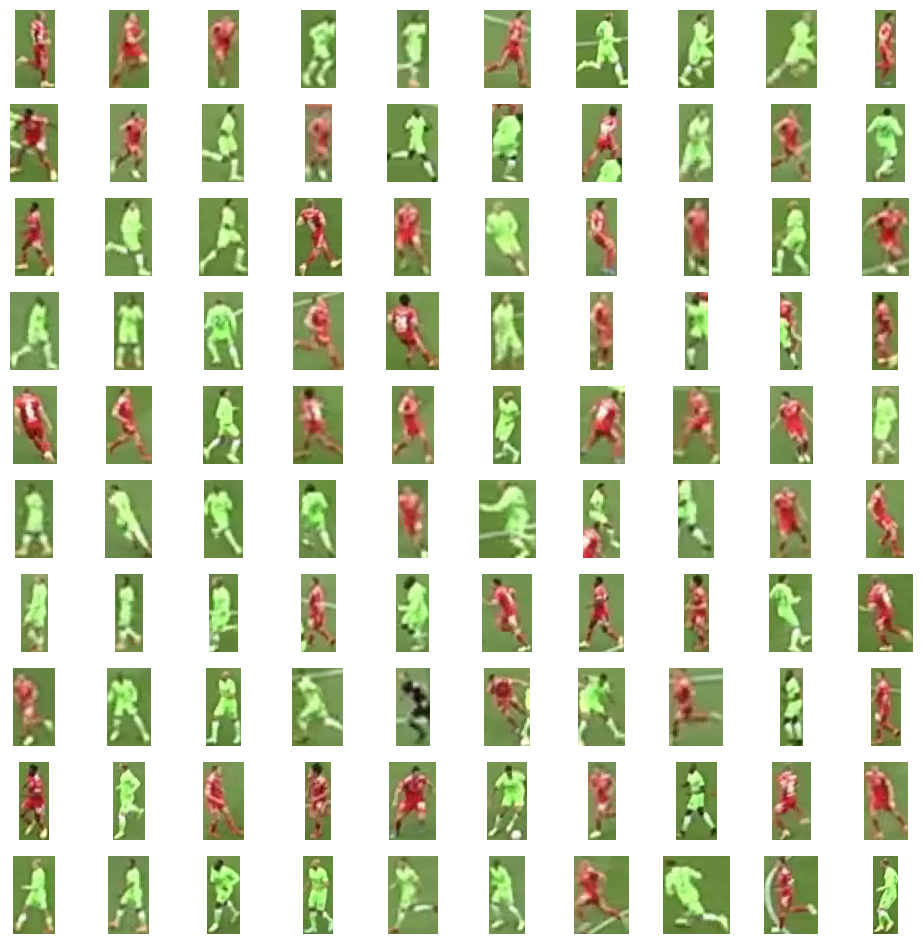

In [26]:
STRIDE = 30
PLAYER_ID = 2

def extract_crops(source_video_path: str):
    frame_generator = sv.get_video_frames_generator(source_video_path, stride=STRIDE)

    crops = []
    for frame in tqdm(frame_generator, desc="collecting crops"):
        result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)
        detections = sv.Detections.from_ultralytics(result[0])
        detections = detections.with_nms(threshold=0.5, class_agnostic=True)
        detections = detections[detections.class_id == PLAYER_ID]

        crops += [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    
    return crops

crops = extract_crops(SOURCE_VIDEO_PATH)

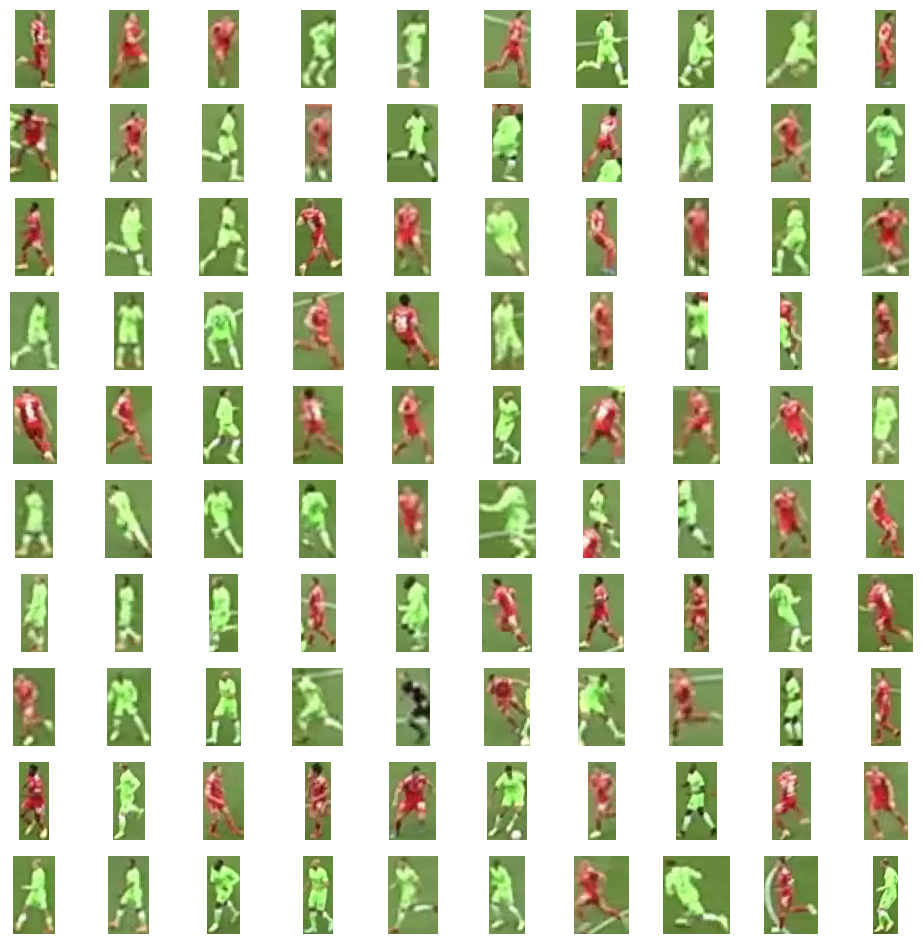

In [34]:
sv.plot_images_grid(crops[:100], grid_size=(10, 10))

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Embedding extraction: 16it [01:39,  6.23s/it]



0: 736x1280 2 goalkeepers, 21 players, 2 referees, 114.7ms
Speed: 6.6ms preprocess, 114.7ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:02,  2.45s/it]


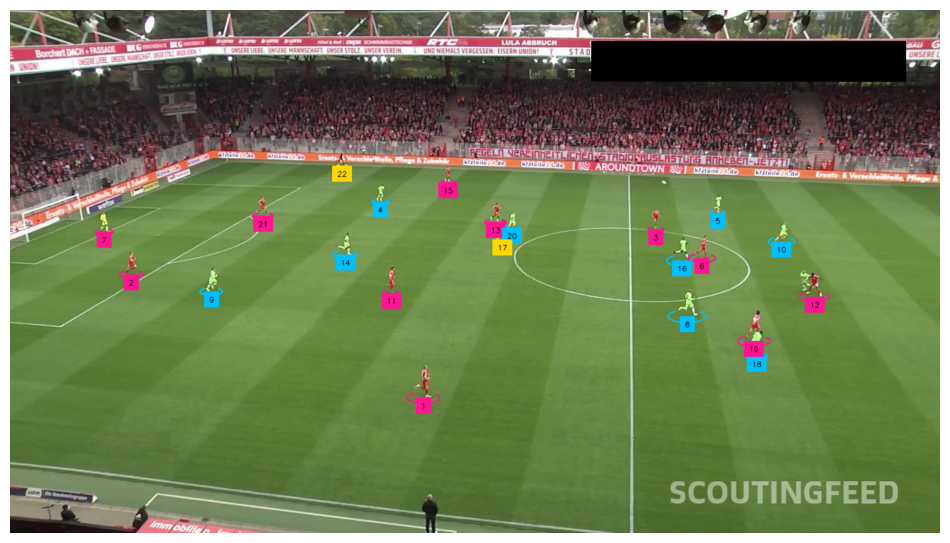

In [16]:
def resolve_goalkeepers_team_id(players_detections: sv.Detections, goalkeepers_detections: sv.Detections):
    goalkeepers_xy = goalkeepers_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)

    team_0_centroid = players_xy[players_detections.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players_detections.class_id == 1].mean(axis=0)

    goalkeepers_team_ids = []
    for xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(xy - team_0_centroid)
        dist_1 = np.linalg.norm(xy - team_1_centroid)
        goalkeepers_team_ids.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_ids)

BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

team_classifier = TeamClassifier(device=DEVICE)
team_classifier.fit(crops)

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), 
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']), 
    text_color=sv.Color.from_hex('#000000'), 
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'), 
    base=20,
    height=17
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)
detections = sv.Detections.from_ultralytics(result[0])

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(all_detections)

players_detections = all_detections[all_detections.class_id == PLAYER_ID]
goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)
goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)

referees_detections.class_id -= 1

all_detections = sv.Detections.merge([players_detections, goalkeepers_detections, referees_detections])

labels = [f"{tracker_id}" for tracker_id in all_detections.tracker_id]

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(annotated_frame, all_detections)
annotated_frame = triangle_annotator.annotate(annotated_frame, ball_detections)
annotated_frame = label_annotator.annotate(annotated_frame, all_detections, labels=labels)

sv.plot_image(annotated_frame)


0: 384x640 1 pitch, 620.4ms
Speed: 2.0ms preprocess, 620.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


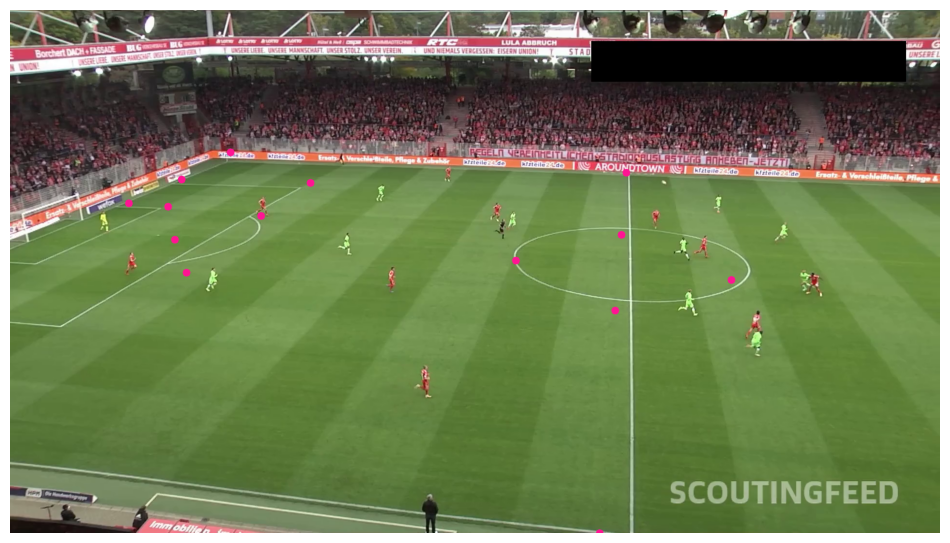

In [18]:
vertex_annotator = sv.VertexAnnotator(color=sv.Color.from_hex("#FF1493"), radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.predict(frame, conf=0.3)
key_points = sv.KeyPoints.from_ultralytics(result[0])

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(xy=frame_reference_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(annotated_frame, frame_reference_key_points)

sv.plot_image(annotated_frame)


0: 384x640 1 pitch, 592.1ms
Speed: 19.1ms preprocess, 592.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


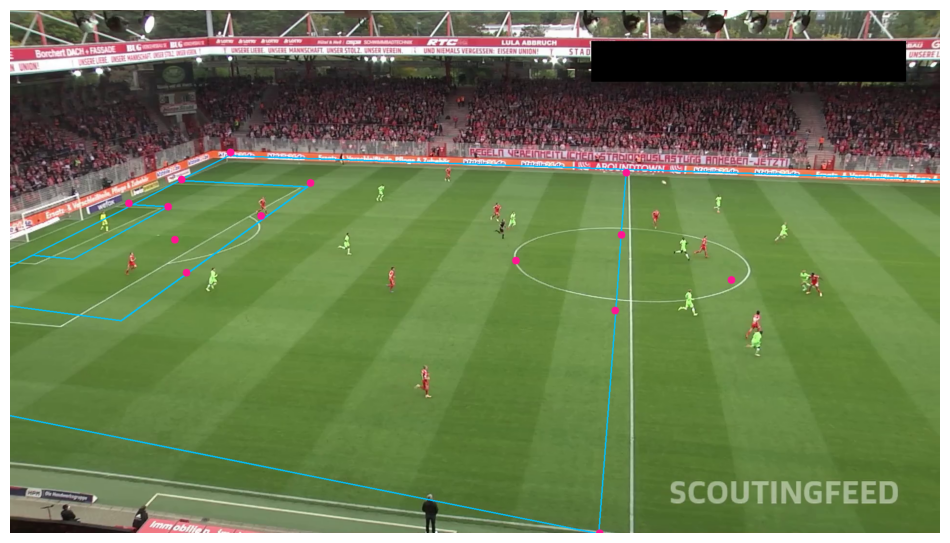

In [22]:
class ViewTransformer:
    def __init__(self, source: np.ndarray, target: np.ndarray):
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m, _ = cv2.findHomography(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        points = points.reshape(-1, 1, 2).astype(np.float32)
        points = cv2.perspectiveTransform(points, self.m)
        return points.reshape(-1, 2).astype(np.float32)

CONFIG = SoccerPitchConfiguration()

vertex_annotator = sv.VertexAnnotator(color=sv.Color.from_hex("#FF1493"), radius=8)
edge_annotator = sv.EdgeAnnotator(color=sv.Color.from_hex("#00BFFF"), thickness=2, edges=CONFIG.edges)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.predict(frame, conf=0.3)
key_points = sv.KeyPoints.from_ultralytics(result[0])

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(xy=frame_reference_points[np.newaxis, ...])
pitch_reference_points = np.array(CONFIG.vertices)[filter]

view_transformer = ViewTransformer(source=pitch_reference_points, target=frame_reference_points)

piths_all_points = np.array(CONFIG.vertices)
frame_all_points = view_transformer.transform_points(piths_all_points)
frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(annotated_frame, frame_all_key_points)
annotated_frame = vertex_annotator.annotate(annotated_frame, frame_reference_key_points)

sv.plot_image(annotated_frame)

In [29]:
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

team_classifier = TeamClassifier(device=DEVICE)
team_classifier.fit(crops)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)
detections = sv.Detections.from_ultralytics(result[0])

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(all_detections)

players_detections = all_detections[all_detections.class_id == PLAYER_ID]
goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)
goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)

result = FIELD_DETECTION_MODEL.predict(frame, conf=0.3)
key_points = sv.KeyPoints.from_ultralytics(result[0])

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(xy=frame_reference_points[np.newaxis, ...])
pitch_reference_points = np.array(CONFIG.vertices)[filter]

view_transformer = ViewTransformer(source=frame_reference_points, target=pitch_reference_points)

frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
if(len(frame_ball_xy) != 0):
    pitch_ball_xy = view_transformer.transform_points(frame_ball_xy)
else:
    pitch_ball_xy = view_transformer.transform_points(np.array([[-970, 415]]))

frame_players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_players_xy = view_transformer.transform_points(frame_players_xy)

frame_referee_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_referee_xy = view_transformer.transform_points(frame_referee_xy)

Embedding extraction: 16it [01:13,  4.58s/it]



0: 736x1280 2 goalkeepers, 21 players, 2 referees, 117.5ms
Speed: 7.6ms preprocess, 117.5ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:02,  2.51s/it]

0: 384x640 1 pitch, 546.0ms
Speed: 2.0ms preprocess, 546.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


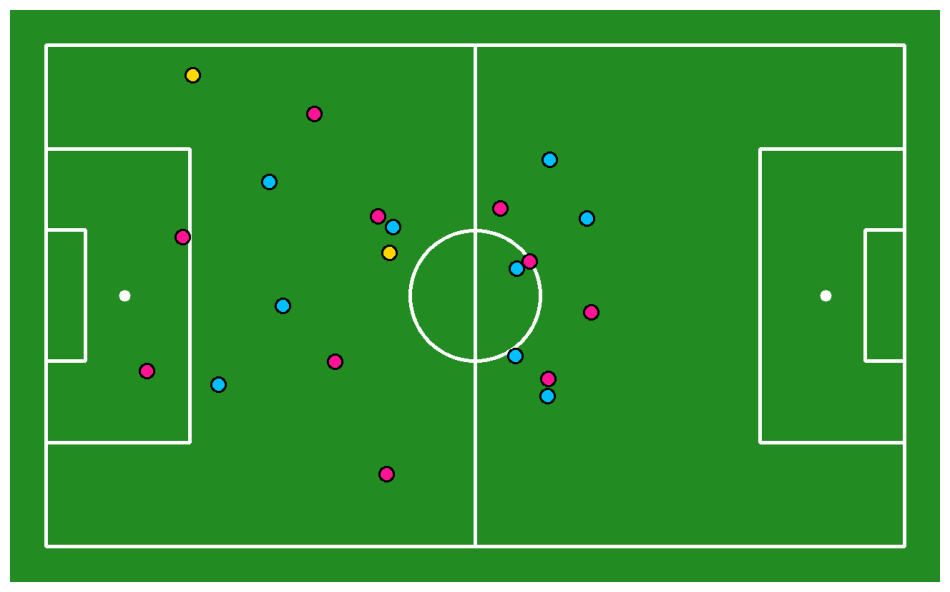

In [30]:
pitch = draw_pitch(config=CONFIG)
pitch = draw_points_on_pitch(config=CONFIG, xy=pitch_ball_xy, face_color=sv.Color.WHITE, edge_color= sv.Color.BLACK, radius=10, pitch=pitch)
pitch = draw_points_on_pitch(config=CONFIG, xy=pitch_players_xy[players_detections.class_id==0], face_color=sv.Color.from_hex("00BFFF"), edge_color= sv.Color.BLACK, radius=10, pitch=pitch)
pitch = draw_points_on_pitch(config=CONFIG, xy=pitch_players_xy[players_detections.class_id==1], face_color=sv.Color.from_hex("#FF1493"), edge_color= sv.Color.BLACK, radius=10, pitch=pitch)
pitch = draw_points_on_pitch(config=CONFIG, xy=pitch_referee_xy, face_color=sv.Color.from_hex("#FFD700"), edge_color= sv.Color.BLACK, radius=10, pitch=pitch)

sv.plot_image(pitch)

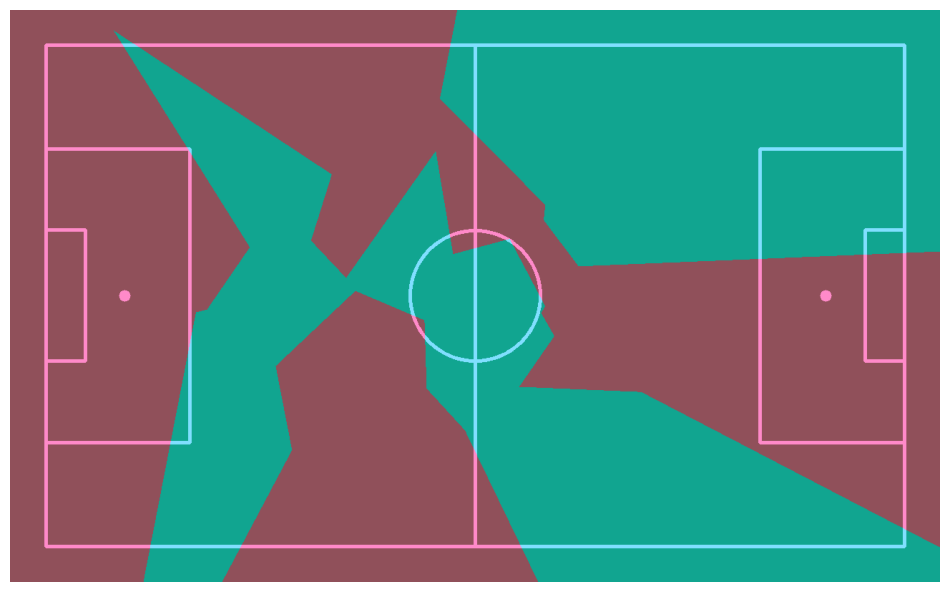

In [31]:
pitch = draw_pitch(config=CONFIG)
pitch = draw_pitch_voronoi_diagram(
    config=CONFIG, 
    team_1_xy=pitch_players_xy[players_detections.class_id==0],
    team_2_xy=pitch_players_xy[players_detections.class_id==1],
    team_1_color=sv.Color.from_hex("00BFFF"),
    team_2_color=sv.Color.from_hex("FF1493"),
    pitch=pitch
)

sv.plot_image(pitch)

  0%|          | 0/750 [00:00<?, ?it/s]


0: 736x1280 2 goalkeepers, 21 players, 2 referees, 117.7ms
Speed: 23.8ms preprocess, 117.7ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 526.1ms
Speed: 2.0ms preprocess, 526.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 2 goalkeepers, 22 players, 2 referees, 111.7ms
Speed: 6.3ms preprocess, 111.7ms inference, 0.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 547.0ms
Speed: 1.9ms preprocess, 547.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 111.6ms
Speed: 6.4ms preprocess, 111.6ms inference, 0.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 384x640 1 pitch, 547.2ms
Speed: 1.9ms preprocess, 547.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 736x1280 1 goalkeeper, 22 players, 2 referees, 111.6ms
Speed: 6.3ms preprocess, 111.6ms inference, 0.8ms postprocess per image at shape (1

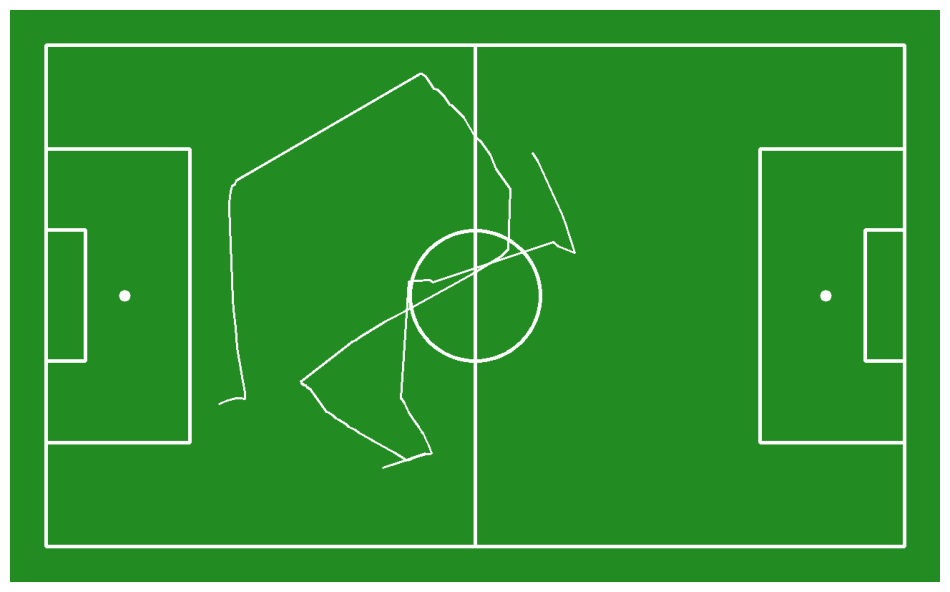

In [32]:
BALL_ID = 0
MAXLEN = 5

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

path_raw = []
M = deque(maxlen=MAXLEN)

for frame in tqdm(frame_generator, total=video_info.total_frames):
    result = PLAYER_DETECTION_MODEL.predict(frame, conf=0.3)
    detections = sv.Detections.from_ultralytics(result[0])

    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)
      
    result = FIELD_DETECTION_MODEL.predict(frame, conf=0.3)
    key_points = sv.KeyPoints.from_ultralytics(result[0])
    
    filter = key_points.confidence[0] > 0.5
    frame_reference_points = key_points.xy[0][filter]
    pitch_reference_points = np.array(CONFIG.vertices)[filter]

    view_transformer = ViewTransformer(source=frame_reference_points, target=pitch_reference_points)
    M.append(view_transformer.m)
    view_transformer.m = np.mean(np.array(M), axis=0)
    
    frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    if(len(frame_ball_xy) != 0):
        pitch_ball_xy = view_transformer.transform_points(frame_ball_xy)
    else:
        # pitch_ball_xy = view_transformer.transform_points(np.array([[-970, 415]]))
        pitch_ball_xy = np.array([[-30000, -30000]]) #view_transformer.transform_points(np.array([[0, 0]]))
        # print(frame_ball_xy, pitch_ball_xy)

    path_raw.append(pitch_ball_xy)

path = [np.empty((0,2), dtype=np.float32) if coordinates.shape[0] >= 2 or np.array_equal(coordinates[0], [-30000, -30000]) else coordinates for coordinates in path_raw]
path = [coordinates.flatten() for coordinates in path]

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_paths_on_pitch(
    config = CONFIG,
    paths=[path],
    color=sv.Color.WHITE,
    pitch=annotated_frame
)

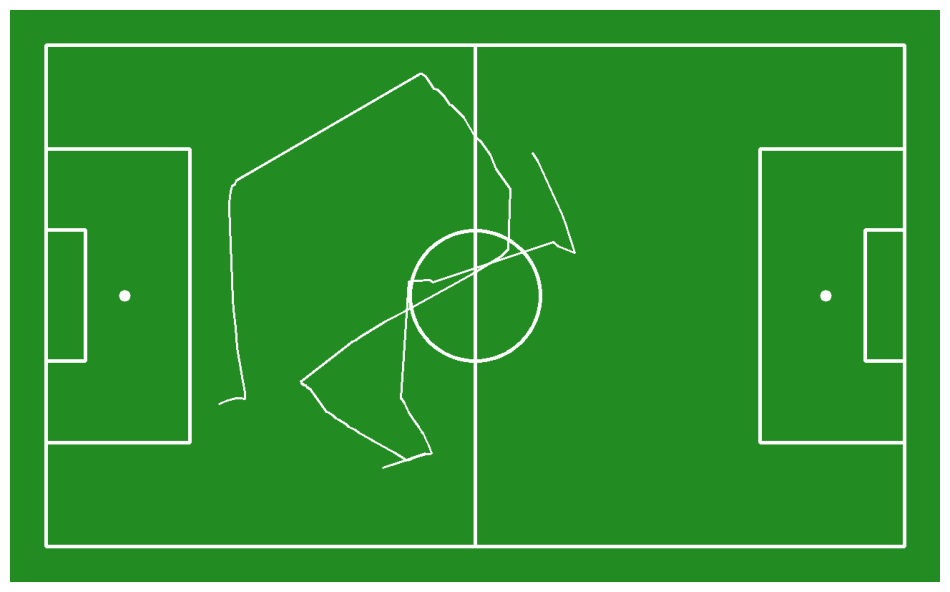

In [33]:
sv.plot_image(annotated_frame)